### O problema analizado é o caixeiro viajante com cidades dispostas ao longo de uma esctrela. O problema é equivalente ao de cidades dispostas ao longo de um circulo, mas com raio variável. Os mínimos continuam sendo os casos em que as cidades seguem ordem crescente ou decrescente.


In [1]:
using LinearAlgebra
using Plots
using TimerOutputs
using Waveforms
using Distributed;
using ProgressMeter
using Profile
using Dagger

#Definiçoes

const cidades = 50
const raioBase = 0.8506508

const fatorNormalizacao = 1
const raioPentagono = (raioBase .+ 0.2*trianglewave.(10*pi.*(0:cidades-1)./(cidades)) .+ 0.2)
const pos = raioPentagono.*[cos.(2 .* pi .* (0:cidades-1) ./ cidades) sin.(2 .* pi .* (0:cidades-1) ./ cidades)];

const ordemOtima = 1:cidades

1:50

In [2]:
using LinearAlgebra

custosTemp = zeros(Float32, cidades, cidades)

for i = 1:cidades
    for j in 1:cidades
        custosTemp[i, j] = norm(pos[i, :]-pos[j, :])
    end
end

const custos = custosTemp;

In [3]:
function J(ordem)
    distTot = 0.0
    for i = 2:cidades
        distTot += custos[ordem[i], ordem[i-1]]    
    end
    
    distTot += custos[ordem[end], ordem[1]]
    
    return distTot
end

J (generic function with 1 method)

In [4]:
function PMX(p1, p2, child)
    csize = length(p1)
    child .= 0
    
    #1
    
    i1 = rand(1:csize)
    i2 = rand(1:csize)

    if i1 > i2
        i1, i2 = i2, i1
    end
    
    child[i1:i2] = p1[i1:i2]
    
    #2
    for i = i1:i2
        rep2 = p2[i]
        found = false
        rep_idx2 = findall(p2 .== rep2)[1]
        if(rep2 in child[i1:i2])
            found = true
        end
        while(!found)
            rep1 = p1[rep_idx2]
            rep_idx1 = findall(p1 .== rep1)[1]
            
            if(rep_idx1 < i1 || rep_idx1 > i2)
                child[rep_idx1] = rep2
                found = true
            else
                rep_idx2 = findall(p2 .== rep1)[1]
            end
        end
    end    
    #3
    
    for i = 1:csize
        if child[i] == 0
            child[i] = p2[i]
        end
    end
    
    return child
end

PMX (generic function with 1 method)

In [5]:
function reverse(A, i1, i2)
    max = length(A)
    for i = i1:i2
        A[i] = A[max-i]
    end
end

reverse (generic function with 1 method)

In [6]:
#SR
function SR(lista, min, proximidade)
    taxa = 0
    rodadas = length(lista)
    
    for l in lista
        if(abs(min - l) <= proximidade)
            taxa += 1/rodadas
        end
    end
    
    return taxa*100
end

using Statistics

#MBF
function MBF(lista, min)   
    return min/mean(lista)
end

#AES
function AES(execsPorIt)
    taxa = 0
    rodadas = 0
    
    for exec in execsPorIt
        if exec > 0
            taxa += exec
            rodadas += 1
        end
    end
    if rodadas > 0
        taxa = taxa/rodadas
    end
    return taxa
end

AES (generic function with 1 method)

In [7]:
function SGA_cidades(Xs, gens, k, Jmin, mu, meme, depth, maxSearch)
    parents = Array{Int16}(undef, k, cidades)
    xhat = Array{Int16}(undef, cidades)
    child = Array{Int16}(undef, cidades)
    Jhist = Array{Float32}(undef, gens)
    execsHist = 0
    scores = Array{Float32}(undef, mu)
    for gen = 1:gens
        # Pontuacao  
        for i = 1:mu
            scores[i] = J(Xs[i, :]);
            execsHist += 1;
        end
        minIdx = argmin(scores)
        Jhist[gen] = scores[minIdx]
        if(abs(Jmin - scores[minIdx]) < 0.001)
#             println("Minimo encontrado");
            Jhist[gen:end] .= Jmin
            return scores[minIdx], Xs[minIdx, :], Jhist, execsHist
        end
        
        # Selecao dos Pais
        topIdx = sortperm(scores, rev=false)
        copy!(parents, Xs[topIdx[1:k], :])
        
        # Crossover
        for i = 1:mu
            p1 = parents[rand(1:k), :]
            p2 = parents[rand(1:k), :]
            
            Xs[i, :] = PMX(p1, p2, child)
        end
        
        # Mutacao
        for i = 1:mu
            i1 = rand(1:cidades)
            i2 = rand(1:cidades)
            if i1 > i2
                i1, i2 = i2, i1
            end
            
            Xs[i, i1:i2] = Xs[i, i2:-1:i1]
            
        end
        
        # Memetico
        if meme
            for i = 1:mu
                for depths = 1:depth
                    Jold = J(Xs[i, :])
                    execsHist[gen] += 1;
                    dJ = 1
                    searches = 0
                    while dJ >=0 && searches < maxSearch
                        copy!(xhat, Xs[i, :])
                        i1 = rand(1:cidades)
                        i2 = rand(1:cidades)
                        if i1 > i2
                            i1, i2 = i2, i1
                        end
                        xhat[i1:i2] = xhat[i2:-1:i1]
                        dJ = J(xhat) - Jold
                        execsHist += 1;
                        searches += 1
                    end
                    if dJ < 0
                        copy!(Xs[i, :], xhat)
                    end
                end
            end
        end
    end
    # Pontuacao
    minIdx = argmin(scores)
#     println("Minimo nao encontrado:");
    execsHist = -1
    return scores[minIdx], Xs[minIdx, :], Jhist, execsHist
end

SGA_cidades (generic function with 1 method)

In [8]:
const mus = [25, 50, 75, 100, 125]
const gens = [100, 200, 300, 400, 500]
const ks = [2, 4, 6, 8, 10]
const runs = [100]

# const mus = [100]
# const gens = [300]
# const ks = [2, 4, 6]
# const runs = [30]

1-element Vector{Int64}:
 100

In [9]:
function idx2grid(idx)
    its = 0
    for mu in mus
        for gen in gens
            for k in ks
                for run in runs
                    its += 1
                    if its == idx
                        return mu, gen, k, run
                    end
                end
            end
        end
    end
    return its
end

idx2grid (generic function with 1 method)

In [10]:
const maxIts = idx2grid(0)

125

In [11]:
using ProgressMeter
using Random

Jmin = J(ordemOtima)
mu = 125
gen = 900
k = 2
run = 100
meme = false
depth = 0
maxSearch = 0

allJmin = zeros(run)
allExecs = zeros(run)
allDistancias = zeros(gen, run)

@showprogress for j = 1:run
    Random.seed!(j);
    
    Xs = Array{Int16}(undef, mu, cidades)
    for i = 1:mu
        Xs[i, :] = shuffle(1:cidades)
    end
     
    time = @elapsed begin
        minS, ~, Jhist, ~ = SGA_cidades(Xs, gen, k, Jmin, mu, meme, depth, maxSearch);
    end
    allDistancias[:, j] = Jhist
    allJmin[j] = minS  
end


LoadError: UndefVarError: Random not defined

In [12]:
using Measures
using Plots

step = 1
plot(allDistancias[:, 1:10:run])
plot!(1:step:gen, ones(gen, 1)*Jmin, label = "Jotimo", lw = 2)


LoadError: UndefVarError: Jmin not defined

In [13]:
using ProgressMeter
using Random


allSR = Array{Float32}(undef, maxIts)
allMBF = Array{Float32}(undef, maxIts)
allAES = Array{Float32}(undef, maxIts)

ploting = false
Jmin = J(ordemOtima)
meme = false
depth = 3
maxSearch = 100
proximidade = 0.001

N = maxIts*sum(runs)
p = Progress(N);
update!(p,0)
jj = Threads.Atomic{Int}(0)

l = Threads.SpinLock()
Threads.@threads for it = 1:maxIts
# for it = 1:maxIts
    mu, gen, k, run = idx2grid(it)
    allJmin = zeros(run)
    allExecs = zeros(run)
    for it = 1:run
        Random.seed!(it);
        Xs = Array{Int16}(undef, mu, cidades)
        for i = 1:mu
            Xs[i, :] = shuffle(1:cidades)   
        end
        minS, ~, ~, execs = SGA_cidades(Xs, gen, k, Jmin, mu, meme, depth, maxSearch);
        allJmin[it] = minS
        allExecs[it] = execs
        
        Threads.atomic_add!(jj, 1)
        Threads.lock(l)
        update!(p, jj[])
        Threads.unlock(l) 
    end
    allSR[it] = SR(allJmin, Jmin, proximidade)
    allMBF[it] = MBF(allJmin, Jmin)
    allAES[it] = AES(allExecs) 
end

Progress: 100%|█████████████████████████████████████████| Time: 0:23:55                                                                            


LoadError: syntax: unexpected "end"

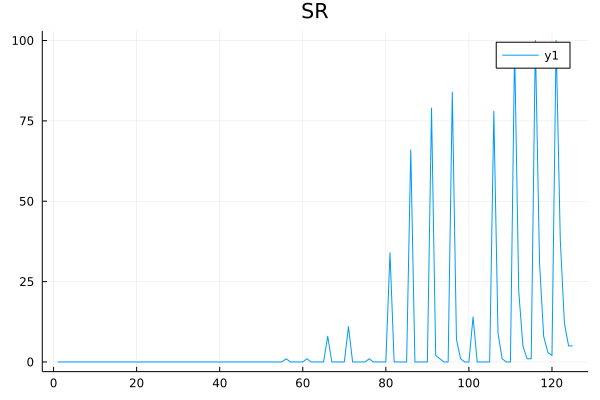

In [25]:
plot(allSR, title = "SR")

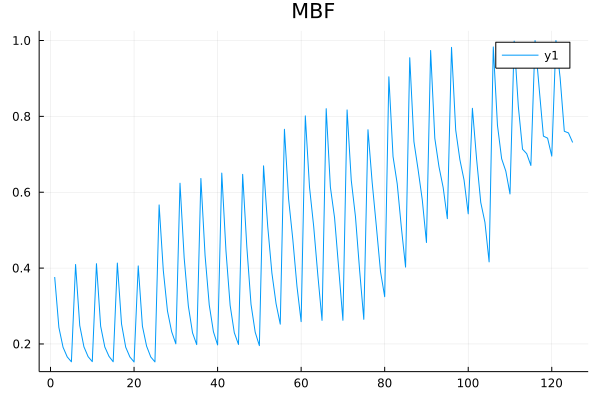

In [26]:
plot(allMBF, title = "MBF")

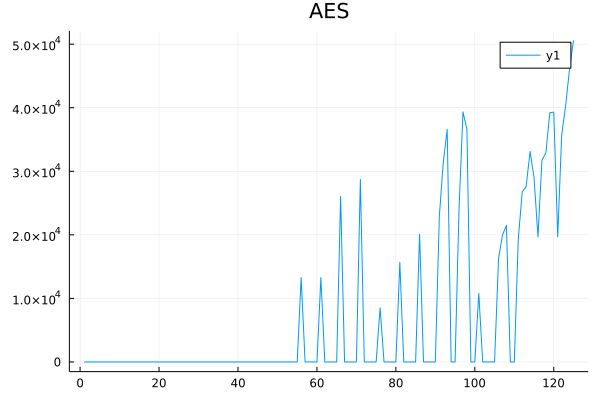

In [27]:
plot(allAES, title = "AES")

In [17]:
idx2grid(1)

(25, 100, 2, 100)

In [18]:
# using Plots

# if ploting
    
#     bOrdem = allOrdemMin[bestCFG, :]
#     bestJ = allJmin[bestCFG]

#     println("Jmin: ", bestJ)
#     println("Jotimo: ", Jmin)
#     plot([0], [0], seriestype = :scatter, xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], size = (500, 500), grid = true)
#     xt(t) = sin(t)*raioBase
#     yt(t) = cos(t)*raioBase
#     plot!(xt, yt, 0, 2*pi, leg=false)
#     plot!(pos[:, 1], pos[:, 2], seriestype = :scatter, mode="markers+text", text=0:cidades-1)

#     quiver!(pos[bOrdem, 1][:],pos[bOrdem, 2][:],quiver=(pos[[bOrdem[2:end]; bOrdem[1]], 1] - pos[bOrdem, 1][:],pos[[bOrdem[2:end]; bOrdem[1]], 2] - pos[bOrdem, 2][:])) 
# end

In [19]:
# if plotting
#     proximidade = 0.001
#     vSR = round(SR(allJmin, Jmin, proximidade), digits=2)
#     vMBF = round(MBF(allJmin), digits=2)
#     vAES = round(AES(allExecs), digits=2)
#     println("SR: ", vSR)
#     println("MBF: ", vMBF)
#     println("AES: ", vAES)
# end

In [20]:

# header: C, SR, MBF, AES, mu, gens, k, runs
for it = 1:maxIts
    mu, gen, k, run = idx2grid(it)
    resultados = string(cidades, ",", allSR[it], ",", allMBF[it], ",", allAES[it], ",", mu, ",", gen, ",", k, ",", run,"\n")
    println(resultados)

    open("resultados_melhor.csv","a") do io
        write(io, resultados)
    end;
end

50,0.0,0.37642634,0.0,25,100,2,100

50,0.0,0.24370113,0.0,25,100,4,100

50,0.0,0.19133028,0.0,25,100,6,100

50,0.0,0.16583411,0.0,25,100,8,100

50,0.0,0.15287769,0.0,25,100,10,100

50,0.0,0.4095299,0.0,25,200,2,100

50,0.0,0.24847433,0.0,25,200,4,100

50,0.0,0.1924282,0.0,25,200,6,100

50,0.0,0.16650108,0.0,25,200,8,100

50,0.0,0.15333886,0.0,25,200,10,100

50,0.0,0.4115991,0.0,25,300,2,100

50,0.0,0.24696092,0.0,25,300,4,100

50,0.0,0.1919802,0.0,25,300,6,100

50,0.0,0.1673327,0.0,25,300,8,100

50,0.0,0.15299045,0.0,25,300,10,100

50,0.0,0.41327915,0.0,25,400,2,100

50,0.0,0.25283894,0.0,25,400,4,100

50,0.0,0.19157334,0.0,25,400,6,100

50,0.0,0.16572393,0.0,25,400,8,100

50,0.0,0.1524796,0.0,25,400,10,100

50,0.0,0.40574715,0.0,25,500,2,100

50,0.0,0.24698818,0.0,25,500,4,100

50,0.0,0.19427437,0.0,25,500,6,100

50,0.0,0.16566776,0.0,25,500,8,100

50,0.0,0.1526705,0.0,25,500,10,100

50,0.0,0.5665092,0.0,50,100,2,100

50,0.0,0.39402455,0.0,50,100,4,100

50,0.0,0.28683043,0.0,50,100,6,